In [80]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense
from keras.models import load_model
from tensorflow.keras.models import load_model

In [81]:
import mediapipe as mp
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
mp.solutions.face_mesh.FACEMESH_TESSELATION

frozenset({(18, 17),
           (82, 38),
           (8, 9),
           (456, 248),
           (167, 2),
           (303, 271),
           (69, 104),
           (253, 450),
           (41, 42),
           (315, 16),
           (73, 74),
           (339, 373),
           (258, 385),
           (105, 63),
           (219, 48),
           (304, 272),
           (236, 217),
           (231, 22),
           (85, 84),
           (365, 367),
           (237, 218),
           (243, 112),
           (436, 427),
           (409, 410),
           (248, 456),
           (330, 266),
           (136, 135),
           (88, 95),
           (394, 430),
           (107, 108),
           (118, 117),
           (439, 438),
           (442, 443),
           (260, 466),
           (115, 48),
           (342, 276),
           (121, 128),
           (200, 421),
           (113, 124),
           (132, 137),
           (23, 230),
           (343, 357),
           (443, 444),
           (62, 78),
           (26,

In [82]:
def mediapipe_detection(image, model):
    """
    Processes an image through Mediapipe holistic model.
    
    Args:
        image (numpy.ndarray): Input BGR image.
        model: Mediapipe Holistic model.
    
    Returns:
        image (numpy.ndarray): Image converted back to BGR.
        results: Mediapipe detection results.
    """
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rgb.flags.writeable = False  # improve performance by marking non-writeable

    # Make prediction
    results = model.process(image_rgb)

    # Convert back to BGR
    image_rgb.flags.writeable = True
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

    return image_bgr, results


In [83]:
def draw_landmarks(image, results):
    """Draws basic landmarks for face, pose, and hands."""
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.face_landmarks,
            mp.solutions.face_mesh.FACEMESH_TESSELATION
        )

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            mp_holistic.POSE_CONNECTIONS
        )

    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS
        )

    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.right_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS
        )


In [84]:
import cv2
import mediapipe as mp

# Initialize webcam
cap = cv2.VideoCapture(0)

# Initialize Mediapipe holistic model
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, 
                                    min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Optional: print results for debugging
        print(results)
        
        # Draw landmarks on frame
        #draw_styled_lndmrks(image, results)

        # Show the frame
        cv2.imshow('OpenCV Feed', image)

        # Break loop on 'q' key press
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Release resources
cap.release()
cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [85]:
draw_landmarks(frame, results)

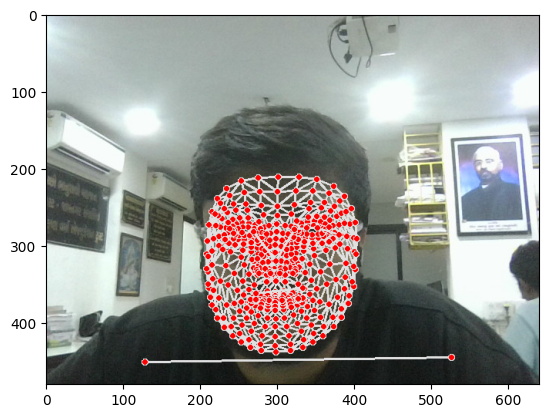

In [86]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [87]:
if results.left_hand_landmarks:
    print(len(results.left_hand_landmarks.landmark))
else:
    print("No left hand detected in this frame")


No left hand detected in this frame


In [88]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [89]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [90]:
if results.face_landmarks:
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()
    print("Face detected")
else:
    face = np.zeros(468*3)


Face detected


In [91]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [92]:
result_test = extract_keypoints(results)

In [93]:
result_test

array([ 0.46673965,  0.66800624, -1.89317322, ...,  0.        ,
        0.        ,  0.        ])

In [94]:
np.save('0', result_test)

In [95]:
np.load('0.npy')

array([ 0.46673965,  0.66800624, -1.89317322, ...,  0.        ,
        0.        ,  0.        ])

In [96]:
import os
import numpy as np

# Path to store exported keypoints as numpy arrays
DATA_PATH = 'MP_Data'

# Define actions to detect
actions = ['hello', 'thanks', 'iloveyou']

# Number of sequences (videos) per action
no_sequences = 30

# Number of frames per sequence
sequence_length = 30

# Starting folder index (useful if appending new data)
start_folder = 30

# Ensure main data directory exists
os.makedirs(DATA_PATH, exist_ok=True)

In [97]:
for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    
    # Create action folder if it doesn't exist
    os.makedirs(action_path, exist_ok=True)
    
    # Find the current maximum sequence number
    existing_sequences = [int(seq) for seq in os.listdir(action_path) if seq.isdigit()]
    dirmax = max(existing_sequences) if existing_sequences else 0
    
    # Create new sequence folders
    for sequence in range(1, no_sequences + 1):
        sequence_folder = os.path.join(action_path, str(dirmax + sequence))
        os.makedirs(sequence_folder, exist_ok=True)


In [98]:
# Loop through each frame in the sequence
for frame_num in range(sequence_length):
    
    # Extract keypoints
    keypoints = extract_keypoints(results)
    
    # Ensure folder exists only once per sequence
    folder_path = os.path.join(DATA_PATH, action, str(sequence))
    os.makedirs(folder_path, exist_ok=True)

    # Save keypoints as .npy file
    npy_path = os.path.join(folder_path, f"{frame_num}.npy")
    np.save(npy_path, keypoints)


In [99]:
def draw_styled_lndmrks(image, results):
    """Draws face, pose, and hand landmarks on the image with custom styles."""

    specs = {
        "face": {"connections": mp.solutions.face_mesh.FACEMESH_TESSELATION, 
                 "landmark_color": (80,110,10), "landmark_thick": 1, "landmark_radius": 1,
                 "connection_color": (80,256,121), "connection_thick": 1, "connection_radius": 1},
        
        "pose": {"connections": mp_holistic.POSE_CONNECTIONS, 
                 "landmark_color": (80,22,10), "landmark_thick": 2, "landmark_radius": 4,
                 "connection_color": (80,44,121), "connection_thick": 2, "connection_radius": 2},
        
        "left_hand": {"connections": mp_holistic.HAND_CONNECTIONS,
                      "landmark_color": (121,22,76), "landmark_thick": 2, "landmark_radius": 4,
                      "connection_color": (121,44,250), "connection_thick": 2, "connection_radius": 2},
        
        "right_hand": {"connections": mp_holistic.HAND_CONNECTIONS,
                       "landmark_color": (245,117,66), "landmark_thick": 2, "landmark_radius": 4,
                       "connection_color": (245,66,230), "connection_thick": 2, "connection_radius": 2}
    }

    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            image, results.face_landmarks, specs["face"]["connections"],
            mp_drawing.DrawingSpec(color=specs["face"]["landmark_color"],
                                   thickness=specs["face"]["landmark_thick"],
                                   circle_radius=specs["face"]["landmark_radius"]),
            mp_drawing.DrawingSpec(color=specs["face"]["connection_color"],
                                   thickness=specs["face"]["connection_thick"],
                                   circle_radius=specs["face"]["connection_radius"])
        )

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, results.pose_landmarks, specs["pose"]["connections"],
            mp_drawing.DrawingSpec(color=specs["pose"]["landmark_color"],
                                   thickness=specs["pose"]["landmark_thick"],
                                   circle_radius=specs["pose"]["landmark_radius"]),
            mp_drawing.DrawingSpec(color=specs["pose"]["connection_color"],
                                   thickness=specs["pose"]["connection_thick"],
                                   circle_radius=specs["pose"]["connection_radius"])
        )

    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results.left_hand_landmarks, specs["left_hand"]["connections"],
            mp_drawing.DrawingSpec(color=specs["left_hand"]["landmark_color"],
                                   thickness=specs["left_hand"]["landmark_thick"],
                                   circle_radius=specs["left_hand"]["landmark_radius"]),
            mp_drawing.DrawingSpec(color=specs["left_hand"]["connection_color"],
                                   thickness=specs["left_hand"]["connection_thick"],
                                   circle_radius=specs["left_hand"]["connection_radius"])
        )

    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, results.right_hand_landmarks, specs["right_hand"]["connections"],
            mp_drawing.DrawingSpec(color=specs["right_hand"]["landmark_color"],
                                   thickness=specs["right_hand"]["landmark_thick"],
                                   circle_radius=specs["right_hand"]["landmark_radius"]),
            mp_drawing.DrawingSpec(color=specs["right_hand"]["connection_color"],
                                   thickness=specs["right_hand"]["connection_thick"],
                                   circle_radius=specs["right_hand"]["connection_radius"])
        )

    return image


In [100]:
import cv2
import os

cap = cv2.VideoCapture(0)

# Set Mediapipe Holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, 
                          min_tracking_confidence=0.5) as holistic:
    
    for action in actions:
        for sequence in range(start_folder, start_folder + no_sequences):
            
            folder_path = os.path.join(DATA_PATH, action, str(sequence))
            os.makedirs(folder_path, exist_ok=True)
            
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                if not ret:
                    continue  # skip if frame not read properly

                # Detect landmarks
                image, results = mediapipe_detection(frame, holistic)

                # Extract keypoints
                keypoints = extract_keypoints(results)
                
                # Save keypoints
                npy_path = os.path.join(folder_path, f"{frame_num}.npy")
                np.save(npy_path, keypoints)

                # Draw landmarks on frame
                draw_styled_lndmrks(image, results)

                # Display info
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action} Video {sequence}', 
                                (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else:
                    cv2.putText(image, f'Collecting frames for {action} Video {sequence}', 
                                (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)

                # Break loop if 'q' pressed
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

cap.release()
cv2.destroyAllWindows()

In [101]:
cap.release()
cv2.destroyAllWindows()

In [102]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [103]:
label_map = {label:num for num, label in enumerate(actions)}

In [104]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [105]:
import os
import numpy as np

sequences, labels = [], []

for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    
    # Get all sequence folders and sort numerically
    sequence_folders = sorted([seq for seq in os.listdir(action_path) 
                               if os.path.isdir(os.path.join(action_path, seq))], 
                              key=lambda x: int(x))
    
    for sequence in sequence_folders:
        sequence_path = os.path.join(action_path, sequence)
        window = []

        # Load all frames in the sequence
        for frame_num in range(sequence_length):
            npy_path = os.path.join(sequence_path, f"{frame_num}.npy")
            if os.path.exists(npy_path):
                frame_data = np.load(npy_path)
                window.append(frame_data)
        
        # Only keep sequences with full length
        if len(window) == sequence_length:
            sequences.append(window)
            labels.append(label_map[action])

# Convert to NumPy arrays
X = np.array(sequences)
y = np.array(labels)

In [106]:
np.array(sequences).shape

(1, 30, 1662)

In [107]:
np.array(labels).shape

(1,)

In [108]:
X = np.array(sequences)

In [109]:
X.shape

(1, 30, 1662)

In [110]:
y = to_categorical(labels).astype(int)

In [111]:
from sklearn.model_selection import train_test_split

# Check number of samples before splitting
if len(X) > 1:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )
else:
    # If there is only 1 sample, use the same data for training and testing
    X_train, X_test, y_train, y_test = X, X, y, y


In [112]:
y_test.shape

(1, 3)

In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [114]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

model = Sequential([
    Input(shape=(30, 1662)),
    LSTM(64, return_sequences=True, activation='relu'),
    Dropout(0.2),
    LSTM(128, return_sequences=True, activation='relu'),
    Dropout(0.2),
    LSTM(64, return_sequences=False, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')  # <-- use len() instead of .shape
])



In [116]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [117]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0000e+00 - loss: 1.1874
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0000e+00 - loss: 1.4006
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.6935
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0000e+00 - loss: 4.0476
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.4226
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0054
Epoch 7/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.2126
Epoch 8/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 9/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 10/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 11/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 12/2000
1/1 ━━━━━━━━━━━━━━━━━━

In [118]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,790,027 (6.83 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,352 (4.55 MB)

In [119]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


In [120]:
actions[np.argmax(res[0])]

'iloveyou'

In [121]:
actions[np.argmax(y_test[0])]

'iloveyou'

In [122]:
import os
print(os.getcwd())

c:\Users\gautam bhanushali\Desktop


In [123]:
import os

search_root = r"C:\Users\gautam bhanushali"  # search inside your user folder
filename_to_find = "action.h5"

found_paths = []
for root, dirs, files in os.walk(search_root):
    if filename_to_find in files:
        found_paths.append(os.path.join(root, filename_to_find))

if found_paths:
    print("Found file(s) at:")
    for path in found_paths:
        print(path)
else:
    print("File not found!")


Found file(s) at:
C:\Users\gautam bhanushali\Desktop\action.h5


In [124]:
model.save('action.h5')

In [125]:
from tensorflow.keras.models import load_model

model = load_model(r"C:\Users\gautam bhanushali\Desktop\action.h5")

In [126]:
model.load_weights('action.h5')

In [127]:
#del model

In [128]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [129]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


In [130]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [131]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[0, 0],
        [0, 1]]], dtype=int64)

In [132]:
accuracy_score(ytrue, yhat)

1.0

In [133]:
from scipy import stats

In [134]:
colors = [(245,117,16), (117,245,16), (16,117,245)]

def prob_viz(res, actions, input_frame, colors):
    """
    Draws colored probability bars on the frame for each action.
    
    Parameters:
    - res: prediction probabilities (array of floats)
    - actions: list of action names
    - input_frame: original frame (BGR)
    - colors: list of RGB tuples for bars
    
    Returns:
    - output_frame: frame with probability bars
    """
    output_frame = input_frame.copy()
    
    for num, prob in enumerate(res):
        # Convert prob to scalar if it's an array or list
        prob = float(prob) if not isinstance(prob, float) else prob

        # Draw the probability bar
        start_point = (0, 60 + num*40)
        end_point = (int(prob*100), 90 + num*40)
        cv2.rectangle(output_frame, start_point, end_point, colors[num], -1)
        
        # Draw the action label
        cv2.putText(output_frame, 
                    actions[num], 
                    (0, 85 + num*40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (255, 255, 255), 2, cv2.LINE_AA)
        
    return output_frame


In [135]:
feature_sequence = []  # keep this outside the loop

while True:
    ret, image = cap.read()  # capture frame from webcam
    if not ret:
        break

    frame_features = extract_features(image)
    feature_sequence.append(frame_features)
    feature_sequence = feature_sequence[-30:]  # keep last 30

    if len(feature_sequence) == 30:
        sequence = np.array(feature_sequence)
        res = model.predict(np.expand_dims(sequence, axis=0))[0]

        output_frame = prob_viz(res, actions, image, colors)
        output_frame_rgb = cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB)

        plt.imshow(output_frame_rgb)
        plt.axis('off')
        plt.show()
    else:
        print(f"Collecting frames... {len(feature_sequence)}/30")



In [136]:
import cv2
import numpy as np
import mediapipe as mp
from collections import deque
from scipy import stats

# Detection variables
sequence = deque(maxlen=30)       # sliding window of 30 frames
predictions = deque(maxlen=10)    # last 10 predictions for smoothing
sentence = []
threshold = 0.5

# Action labels
actions = ['hello', 'thanks', 'iloveyou']  # replace with your actions
colors = [(245,117,16), (117,245,16), (16,117,245)]

# Open webcam
cap = cv2.VideoCapture(0)

# Initialize Mediapipe Holistic model
with mp.solutions.holistic.Holistic(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
) as holistic:

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Mediapipe detection
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_lndmrks(image, results)

        # Extract keypoints and add to sequence
        keypoints = extract_keypoints(results)  # should return 1D vector matching model input
        sequence.append(keypoints)

        # Predict only if sequence has 30 frames
        if len(sequence) == 30:
            seq_array = np.array(sequence)
            res = model.predict(np.expand_dims(seq_array, axis=0))[0]  # shape: (num_actions,)
            predicted_action = np.argmax(res)
            predictions.append(predicted_action)

            # Smooth predictions using mode (works with latest SciPy)
            if len(predictions) == 10:
                most_common = stats.mode(list(predictions), keepdims=True).mode[0]
                if res[most_common] > threshold:
                    if len(sentence) == 0 or actions[most_common] != sentence[-1]:
                        sentence.append(actions[most_common])

            # Keep last 5 words in sentence
            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Visualization of probabilities
            image = prob_viz(res, actions, image, colors)

        # Display recognized sentence
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show feed
        cv2.imshow('OpenCV Feed', image)

        # Exit on 'q'
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Release resources
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━